# Plan expérimental: Visualisation d'image après une forte compression avec l'autoencoder

## Introduction
Dans ce notebook, nous construisons un plan expérimental sur la visualisation des données avec l'autoencoder. On peut définir un auto encodeur comme un réseau de neurones qui est utilisé pour l'apprentissage non supervisé de caractéristique discriminantes. Il peut être divisé en deux grandes parties:
- encodeur: cette partie prend en entrée les données en grande dimension que l'on souhaite compresser vers des données en plus petite dimension
- decodeur: ici on prend en entrée les données de petite dimension sortant de la partie encodeur et on les retroprojette dans une grande dimension
<br><br>
L'apprentissage avec l'autoencoder a plusieurs applications, dans ce cas présent nous on s'intéresse à la compression d'image

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sequentiel import Sequentiel
from module import Module, Linear
from loss import BCE
from optim import Optim, creer_mini_batches
from activation import TanH, Sigmoide
import os
from time import time
from relu import Relu
from autoencoder import Autoencoder, AutoencoderNoisy, add_noise

## Dataset
Pour nos expériences ont choisi d'utiliser les données de USPS qui représente des chiffres de (0 à 9) manuscrites et qui sont composé de 256 pixels (16x16) par images. Ce sont des données qui sont assez utiliser pour faire de la classification ce qui n'est pas notre cas ici. Cependant elles restent également adaptées à nos besoins pour mener nos expériences.

#### Lecture des données

On a bien 10 chiffres (0 à 9) et on a une base d'apprentissage constitué de 7291 exemples. Et les valeurs des pixels de nos images sont tous des réels entre (0 et 1)

In [2]:
with h5py.File('../usps.h5', 'r') as hf:
    train = hf.get('train')
    X_tr = train.get('data')[:]
    y_tr = train.get('target')[:]
    test = hf.get('test')
    X_te = test.get('data')[:]
    y_te = test.get('target')[:]
print("Taille des données en train: ", X_tr.shape)
print("Taille des données en test: ", X_te.shape)
print("Classe des données en train: ", np.unique(y_tr))
print("Classe des données en test: ", np.unique(y_te))
print("Valeurs des pixels d'une image: ",np.unique(X_tr[0]))
print("Intervalles de valeur des données: ",np.unique(np.min(X_tr, axis=1))," à ", np.unique(np.max(X_tr, axis=1)))

Taille des données en train:  (7291, 256)
Taille des données en test:  (2007, 256)
Classe des données en train:  [0 1 2 3 4 5 6 7 8 9]
Classe des données en test:  [0 1 2 3 4 5 6 7 8 9]
Valeurs des pixels d'une image:  [0.         0.0025     0.00400001 0.0045     0.00650001 0.01300001
 0.01949999 0.02500001 0.02849999 0.02900001 0.03099999 0.03749999
 0.04750001 0.0485     0.058      0.08399999 0.088      0.1015
 0.1275     0.1385     0.14250001 0.143      0.15849999 0.1615
 0.18450001 0.185      0.2175     0.225      0.25849998 0.263
 0.274      0.2805     0.2855     0.29500002 0.37150002 0.4075
 0.4165     0.419      0.44550002 0.4625     0.5135     0.534
 0.546      0.55       0.5565     0.5675     0.5725     0.592
 0.6095     0.639      0.64849997 0.65       0.652      0.6535
 0.654      0.6635     0.6705     0.6775     0.741      0.7425
 0.768      0.77       0.77250004 0.781      0.8205     0.8275
 0.8535     0.8765     0.889      0.896      0.906      0.9065
 0.9115     0.9125  

#### Visualisation des données
Même si ce n'est pas indispensable dans ce cas d'étude, regardons un peu la distribution de nos classes dans notre jeu de données

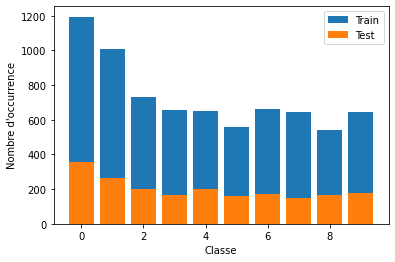

In [3]:
frequency = np.unique(y_tr, return_counts=True)
plt.figure()
plt.bar(frequency[0], frequency[1], label="Train")
frequency = np.unique(y_te, return_counts=True)
plt.bar(frequency[0], frequency[1], label="Test")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrence")
plt.legend()

In [6]:
X_tr[0].shape

(256,)

In [2]:
def getSampleIndex(y, occur=1):
    """ Retourne les indices des images représentant les chiffres de 0 à 9. Il utilise de l'aléa ce qui ne garanti pas qu'il renvoie à chaque fois les mêmes images """
    result = []
    for i in np.arange(10):
        result.extend(list(np.random.choice(np.argwhere(y==i).reshape(-1), occur))) 
    return np.array(result)

def imgGrid(ims, rows=None, cols=None, fill=True, showax=False, filename=None):
    if rows is None != cols is None:
        raise ValueError("Pas de valeurs spécifier pour les paramètres rows et cols.")

    if rows is None:
        rows = len(ims)
        cols = 1

    plt.figure()
    gridspec_kw = {'wspace': 0, 'hspace': 0} if fill else {}
    fig,axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw)

    if fill:
        bleed = 0
        fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax,im in zip(axarr.ravel(), ims):
        ax.imshow(im.reshape((16,16)),interpolation="nearest",cmap="gray")
        if not showax:
            ax.set_axis_off()

    kwargs = {'pad_inches': .01} if fill else {}
    if filename:
        output_dir = 'output'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    # fig.savefig("../digits_insights.jpg", **kwargs)
        fig.savefig(output_dir+"/"+filename, **kwargs)

<Figure size 432x288 with 0 Axes>

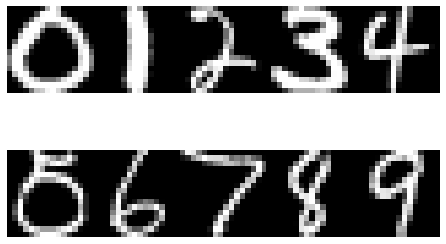

In [4]:
sample = X_tr[getSampleIndex(y_tr)]
imgGrid(sample, rows=2, cols=5)

In [3]:
def plot_loss(loss_data, title=""):
    plt.figure()
    plt.plot(loss_data)
    plt.xlabel("Epoch")
    plt.ylabel("Cout")
    plt.title(title)
    plt.legend()
    plt.savefig("../AE_reconstruction_image_2.jpg")
    plt.show()

def summary(sample):
    reconstructed_sample = AE.reconstruct(sample)
    print("Aperçu de l'échantillon à reconstruire")
    imgGrid(sample, rows=1, cols=sample.shape[0])
    print("Aperçu de l'échantillon reconstruite")
    imgGrid(reconstructed_sample, rows=1, cols=reconstructed_sample.shape[0])
    print("\nObservation de l'erreur entre donnée originale et la donnée reconstruite")
    # print(AE.getLossFunction().forward(sample, reconstructed_sample).mean())
    print(reconstruction_error(sample, reconstructed_sample))
    

In [ ]:
AE = Autoencoder(Sequentiel([
    # encoder
    Conv1D(4, 1, 3, 4),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(96, 50),
    Relu(),
    Linear(50, 10)
    # decoder
    Sigmoide(),
    Linear(50, 10),
    Relu(),
    Linear(96, 50),
    Flatten(),
    MaxPool1D(2, 2),
    Conv1D(4, 1, 3, 4),
    
    ]), BCE(), learning_rate=LEARNING_RATE)
LEARNING_RATE = 1e-3
BATCH_SIZE = 30
MAX_ITER=300

In [80]:
AE = Autoencoder(Sequentiel([
    # encoder
    Linear(X_tr.shape[1], 100),
    TanH(),
    Linear(100, 10),
    TanH(),
    # decoder
    Linear(10, 100),
    TanH(),
    Linear(100, X_tr.shape[1]),
    Sigmoide()
    ]), BCE(), learning_rate=LEARNING_RATE)
LEARNING_RATE = 1e-3
BATCH_SIZE = 30
MAX_ITER=300

In [81]:
start = time()
train_loss = AE.train(X_tr, max_iter=MAX_ITER, size_per_batch=BATCH_SIZE)
runTime = round(time()-start, 3)

Epoch 10/300 avec un coût de 0.384
Epoch 20/300 avec un coût de 0.371
Epoch 30/300 avec un coût de 0.366
Epoch 40/300 avec un coût de 0.361
Epoch 50/300 avec un coût de 0.358
Epoch 60/300 avec un coût de 0.359
Epoch 70/300 avec un coût de 0.350
Epoch 80/300 avec un coût de 0.343
Epoch 90/300 avec un coût de 0.335
Epoch 100/300 avec un coût de 0.331
Epoch 110/300 avec un coût de 0.327
Epoch 120/300 avec un coût de 0.327
Epoch 130/300 avec un coût de 0.323
Epoch 140/300 avec un coût de 0.323
Epoch 150/300 avec un coût de 0.320
Epoch 160/300 avec un coût de 0.321
Epoch 170/300 avec un coût de 0.316
Epoch 180/300 avec un coût de 0.314
Epoch 190/300 avec un coût de 0.314
Epoch 200/300 avec un coût de 0.312
Epoch 210/300 avec un coût de 0.310
Epoch 220/300 avec un coût de 0.308
Epoch 230/300 avec un coût de 0.310
Epoch 240/300 avec un coût de 0.311
Epoch 250/300 avec un coût de 0.306
Epoch 260/300 avec un coût de 0.307
Epoch 270/300 avec un coût de 0.306
Epoch 280/300 avec un coût de 0.305
E

In [73]:
print(runTime)

964.811


No handles with labels found to put in legend.


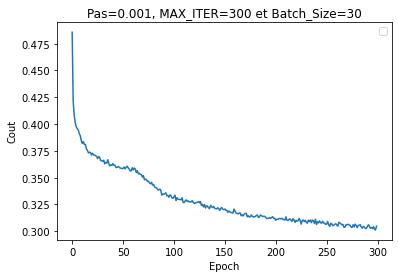

In [82]:
plot_loss(train_loss, title = "Pas="+str(LEARNING_RATE)+", MAX_ITER="+str(MAX_ITER)+" et Batch_Size="+str(BATCH_SIZE))

In [48]:
def reconstruction_error(X, X_hat):
    return np.abs(np.subtract(X, X_hat)).mean()

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.1772661704623243


<Figure size 432x288 with 0 Axes>

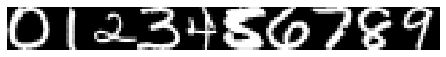

<Figure size 432x288 with 0 Axes>

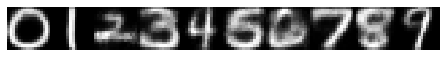

In [115]:
# prenons de façon aléatoire un exemple par chiffre de 0 à 9
sample = X_te[getSampleIndex(y_te)]
summary(sample)

### Autre architecture


In [136]:
AE = Autoencoder(Sequentiel([
    # encoder
    Linear(X_tr.shape[1], 100),
    Sigmoide(),
    Linear(100, 64),
    Sigmoide(),
    Linear(64, 10),
    Sigmoide(),
    # decoder
    Linear(10, 64),
    Sigmoide(),
    Linear(64, 100),
    Sigmoide(),
    Linear(100, X_tr.shape[1]),
    Sigmoide()
    ]), BCE(), learning_rate=LEARNING_RATE)# 9e-4
LEARNING_RATE = 5e-4
BATCH_SIZE = 15
MAX_ITER=300
start = time()
train_loss = AE.train(X_tr, max_iter = MAX_ITER, size_per_batch=BATCH_SIZE)
runTime = round(time()-start, 2)

Epoch 10/300 avec un coût de 0.273
Epoch 20/300 avec un coût de 0.247
Epoch 30/300 avec un coût de 0.234
Epoch 40/300 avec un coût de 0.226
Epoch 50/300 avec un coût de 0.221
Epoch 60/300 avec un coût de 0.217
Epoch 70/300 avec un coût de 0.215
Epoch 80/300 avec un coût de 0.212
Epoch 90/300 avec un coût de 0.210
Epoch 100/300 avec un coût de 0.209
Epoch 110/300 avec un coût de 0.207
Epoch 120/300 avec un coût de 0.207
Epoch 130/300 avec un coût de 0.206
Epoch 140/300 avec un coût de 0.205
Epoch 150/300 avec un coût de 0.204
Epoch 160/300 avec un coût de 0.202
Epoch 170/300 avec un coût de 0.202
Epoch 180/300 avec un coût de 0.201
Epoch 190/300 avec un coût de 0.201
Epoch 200/300 avec un coût de 0.201
Epoch 210/300 avec un coût de 0.200
Epoch 220/300 avec un coût de 0.199
Epoch 230/300 avec un coût de 0.199
Epoch 240/300 avec un coût de 0.198
Epoch 250/300 avec un coût de 0.198
Epoch 260/300 avec un coût de 0.199
Epoch 270/300 avec un coût de 0.198
Epoch 280/300 avec un coût de 0.197
E

In [137]:
print(runTime)

1191.44


No handles with labels found to put in legend.


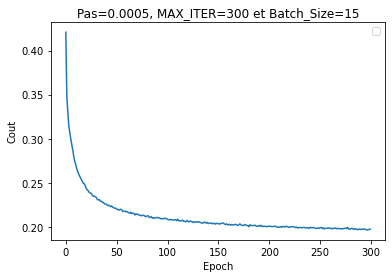

In [138]:
plot_loss(train_loss, title = "Pas="+str(LEARNING_RATE)+", MAX_ITER="+str(MAX_ITER)+" et Batch_Size="+str(BATCH_SIZE))

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.08340167818855482


<Figure size 432x288 with 0 Axes>

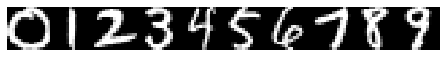

<Figure size 432x288 with 0 Axes>

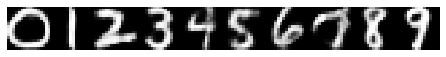

In [150]:
# Erreur min avec cet architecture: 0.1908895893306616 batch [30]
# np.min(train_loss)
# prenons de façon aléatoire un exemple par chiffre de 0 à 9
sample = X_te[getSampleIndex(y_te)]
summary(sample)

### Bruitons une échantillon d'image et observons

On rappelle que l'autoencodeur utilisé là a appris les données images non bruitées. Bruitons les données de quelques images et voyons si notre réseau est capable de repérer les éléments caractéristiques des images

> Il les a reconnu et a bien extrait les elements discriminants les images du bruit (Par contre plus le bruit est fort plus c'est plus compliqué de recupérer les traits significatifs des images bruités: dans la *section 2* nous intégrerons les données bruitées dans l'apprentissage directement pour améliorer les perfomances)

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.19787459968486343


<Figure size 432x288 with 0 Axes>

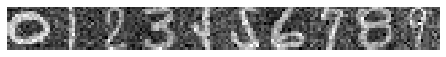

<Figure size 432x288 with 0 Axes>

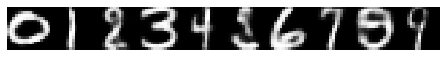

In [145]:
noisy_sample = sample + 0.2 * np.random.randn(sample.shape[0], sample.shape[1])
summary(noisy_sample)

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.2708829914961237


<Figure size 432x288 with 0 Axes>

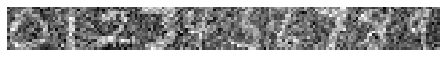

<Figure size 432x288 with 0 Axes>

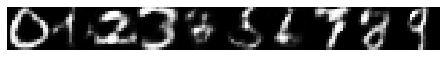

In [77]:
noisy_sample = sample + 0.4 * np.random.randn(sample.shape[0], sample.shape[1])
summary(noisy_sample)

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.11840105229899897


<Figure size 432x288 with 0 Axes>

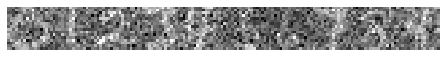

<Figure size 432x288 with 0 Axes>

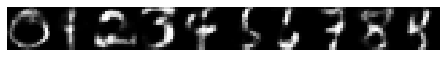

In [78]:
noisy_sample = sample + 0.6 * np.random.randn(sample.shape[0], sample.shape[1])
summary(noisy_sample)

### Autre architecture avec un code plus petit (8)
> Les performances sont en géneral bonne d'après les tests effectués

In [92]:
AE = Autoencoder(Sequentiel([
    # encoder
    Linear(X_tr.shape[1], 160),
    Sigmoide(),
    Linear(160, 60),
    Sigmoide(),
    Linear(60, 32),
    Sigmoide(),
    Linear(32, 8),
    Sigmoide(),
    # decoder
    Linear(8, 32),
    Sigmoide(),
    Linear(32, 60),
    Sigmoide(),
    Linear(60, 160),
    Sigmoide(),
    Linear(160, X_tr.shape[1]),
    Sigmoide()
    ]), BCE(), learning_rate=9e-4)
train_loss = AE.train(X_tr, y_tr.reshape(-1, 1), max_iter = 300, size_per_batch=25)

Epoch 1/300 avec un coût de 0.493
Epoch 2/300 avec un coût de 0.451
Epoch 3/300 avec un coût de 0.413
Epoch 4/300 avec un coût de 0.396
Epoch 5/300 avec un coût de 0.385
Epoch 6/300 avec un coût de 0.375
Epoch 7/300 avec un coût de 0.367
Epoch 8/300 avec un coût de 0.360
Epoch 9/300 avec un coût de 0.355
Epoch 10/300 avec un coût de 0.351
Epoch 11/300 avec un coût de 0.347
Epoch 12/300 avec un coût de 0.344
Epoch 13/300 avec un coût de 0.340
Epoch 14/300 avec un coût de 0.337
Epoch 15/300 avec un coût de 0.333
Epoch 16/300 avec un coût de 0.329
Epoch 17/300 avec un coût de 0.325
Epoch 18/300 avec un coût de 0.321
Epoch 19/300 avec un coût de 0.317
Epoch 20/300 avec un coût de 0.314
Epoch 21/300 avec un coût de 0.311
Epoch 22/300 avec un coût de 0.308
Epoch 23/300 avec un coût de 0.306
Epoch 24/300 avec un coût de 0.304
Epoch 25/300 avec un coût de 0.302
Epoch 26/300 avec un coût de 0.299
Epoch 27/300 avec un coût de 0.297
Epoch 28/300 avec un coût de 0.296
Epoch 29/300 avec un coût de 

No handles with labels found to put in legend.


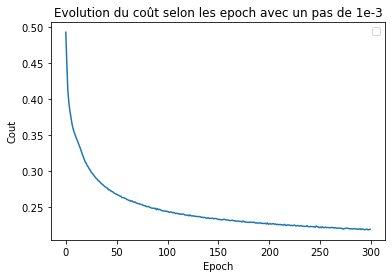

In [93]:
plot_loss(train_loss)

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon reconstruite

Observation de l'erreur entre donnée originale et la donnée reconstruite
0.23005599897284182


<Figure size 432x288 with 0 Axes>

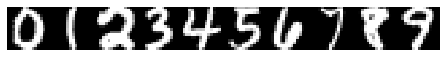

<Figure size 432x288 with 0 Axes>

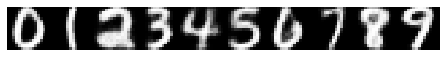

In [97]:
# prenons de façon aléatoire un exemple par chiffre de 0 à 9
sample = X_te[getSampleIndex(y_te)]
summary(sample)

# Plan expérimental: Débruitage des données avec l'autoencoder

## Introduction
Dans ce notebook, nous construisons un plan expérimental sur le débruitage des données avec l'autoencoder. On peut définir un auto encodeur comme un réseau de neurones qui est utilisé pour l'apprentissage non supervisé de caractéristique discriminantes. Il peut être divisé en deux grandes parties:
- encodeur: cette partie prend en entrée les données en grande dimension que l'on souhaite compresser vers des données en plus petite dimension
- decodeur: ici on prend en entrée les données de petite dimension sortant de la partie encodeur et on les retroprojette dans une grande dimension
<br><br>
L'apprentissage avec l'autoencoder a plusieurs applications, dans ce cas présent nous on s'intéresse au débruitage des données. 

## Démarches Auto encodeur débruiteur

Pour parvenir à mettre enplace notre autoencodeur débruiteur de données, il nous faudrait l'entrainer sur nos données. Pour cela il est nécessaire dans un premier temps de choisir une architecture pour notre réseaux de neurones. Dans un premier temps on va partir sur l'architecture suivante:

- Encodeur: Linear(256,100) → Sigmoide() → Linear(100,10) → Sigmoide()
- Decodeur: Linear(10,100) → Sigmoide() → Linear(100,256) → Sigmoide()

Dans la partie précédente on a bien remarqué que les valeurs des pixels des images sont bien entre 0 et 1 ce pourquoi on a choisi d'utiliser la fonction Sigmoide sur les données de sorties. Dans le processus d'entrainement de notre autoencodeur, il nous faut choisir une fonction de coût pour calculer la perte sur les données de sorties (X') par rapport au données d'entrée (X). Ce cout est appelé **coût de reconstruction** et se note en général $$L(X, X')$$
Par contre avec l'autoencodeur débruiteur on va bruité les données X de façon stochastique ce qui va nous donner des données $\tilde{X}$ corrompu qu'on va utiliser comme entrée de notre réseau et le calcul du côut se fera comme suit $$L(X, \tilde{X}')$$

 La fonction de perte L sera la fonction BCE (Binary cross entropy)

 > Pour notre autoencodeur ce sont les données bruitées qui sont utilisé pour l'apprentissage

In [151]:
class AutoencoderNoisy:
    """ AutoEncodeur débruiteur """
    def __init__(self, net, fLoss, learning_rate=1e-3, noise_eps=0.3):
        self.optim = Optim(net, fLoss, learning_rate)
        self.noise_eps = noise_eps
    
    def train(self, features, labels, max_iter=30, size_per_batch = 30):
        """ Fonction de train d'un autoencodeur """
        train_loss = [] # sauvegarder les coûts durant chaque epoch

        for epoch in range(max_iter):
            current_loss = 0 # accumule le coût durant une epoch pour les batch
            allbatches = creer_mini_batches(features, labels, size_per_batch) # création de batch
            for datax, _ in allbatches:
                # ajout du bruit aux données
                datax_noisy = add_noise(datax, eps=self.noise_eps)
                #ramener les valeurs entre 0. et 1. par seuillage
                datax_noisy = np.clip(datax_noisy, 0., 1.)
                self.optim.step(datax_noisy, datax)

                current_loss += self.optim.loss_value
            train_loss.append(current_loss/len(allbatches))
            if epoch%10==0:
                print("Epoch {}/{} avec un coût de {:.3f}".format(epoch+1, max_iter, current_loss/len(allbatches)))
        return train_loss

    def getAutoencoder(self):
        return self.optim.net

    def getLossFunction(self):
        return self.optim.loss

    def reconstruct(self, data):
        """ Reconstruis les données après les avoir bruité. On utilise le réseau appris pour reconstruire les données 
        RETURN: (data_noisy, data_reconstructed, loss_between_original_data_and_reconstructed_data)
        """
        data_noisy = add_noise(data, eps=self.noise_eps)
        data_noisy = np.clip(data_noisy, 0.0, 1.0)
        output = self.optim.net.forward(data_noisy)
        return data_noisy, output
    


In [14]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 25
MAX_ITER=300

AED = AutoencoderNoisy(Sequentiel([
    # encoder
    Linear(X_tr.shape[1], 100),
    Sigmoide(),
    Linear(100, 10),
    Sigmoide(),
    # decoder
    Linear(10, 100),
    Sigmoide(),
    Linear(100, X_tr.shape[1]),
    Sigmoide()
    ]), BCE(), learning_rate=LEARNING_RATE)

start = time()
train_loss = AED.train(X_tr, y_tr.reshape(-1, 1), max_iter = MAX_ITER, size_per_batch=BATCH_SIZE)
runTime = round(time()-start, 2)

Epoch 1/300 avec un coût de 0.475
Epoch 11/300 avec un coût de 0.304
Epoch 21/300 avec un coût de 0.282
Epoch 31/300 avec un coût de 0.267
Epoch 41/300 avec un coût de 0.254
Epoch 51/300 avec un coût de 0.246
Epoch 61/300 avec un coût de 0.241
Epoch 71/300 avec un coût de 0.236
Epoch 81/300 avec un coût de 0.231
Epoch 91/300 avec un coût de 0.228
Epoch 101/300 avec un coût de 0.226
Epoch 111/300 avec un coût de 0.224
Epoch 121/300 avec un coût de 0.222
Epoch 131/300 avec un coût de 0.220
Epoch 141/300 avec un coût de 0.219
Epoch 151/300 avec un coût de 0.218
Epoch 161/300 avec un coût de 0.217
Epoch 171/300 avec un coût de 0.216
Epoch 181/300 avec un coût de 0.215
Epoch 191/300 avec un coût de 0.214
Epoch 201/300 avec un coût de 0.213
Epoch 211/300 avec un coût de 0.213
Epoch 221/300 avec un coût de 0.212
Epoch 231/300 avec un coût de 0.212
Epoch 241/300 avec un coût de 0.211
Epoch 251/300 avec un coût de 0.210
Epoch 261/300 avec un coût de 0.209
Epoch 271/300 avec un coût de 0.209
Epo

In [ ]:
print(runTime)

No handles with labels found to put in legend.


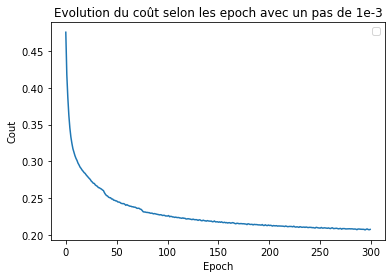

In [15]:
plot_loss(train_loss)

Aperçu de l'échantillon à reconstruire
Aperçu de l'échantillon bruité à reconstruire
Aperçu de l'échantillon reconstruite à partir des données bruitées

Observation de l'erreur entre donnée originale non bruité et la donnée reconstruite
0.22266161965652223

Observation de l'erreur entre donnée bruité et la donnée reconstruite
0.8935144439496199


<Figure size 432x288 with 0 Axes>

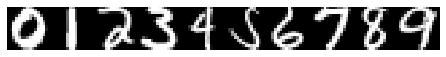

<Figure size 432x288 with 0 Axes>

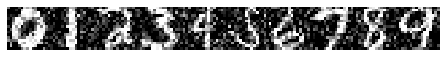

<Figure size 432x288 with 0 Axes>

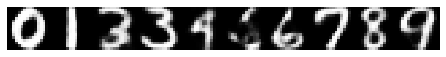

In [17]:
sample = X_te[getSampleIndex(y_te)]
sample_noisy, reconstructed_sample = AED.reconstruct(sample)
print("Aperçu de l'échantillon à reconstruire")
imgGrid(sample, rows=1, cols=sample.shape[0])
print("Aperçu de l'échantillon bruité à reconstruire")
imgGrid(sample_noisy, rows=1, cols=sample_noisy.shape[0])
print("Aperçu de l'échantillon reconstruite à partir des données bruitées")
imgGrid(reconstructed_sample, rows=1, cols=reconstructed_sample.shape[0])
print("\nObservation de l'erreur entre donnée originale non bruité et la donnée reconstruite")
print(AED.getLossFunction().forward(sample, reconstructed_sample).mean())
print("\nObservation de l'erreur entre donnée bruité et la donnée reconstruite")
print(AED.getLossFunction().forward(sample_noisy, reconstructed_sample).mean())

### Observation
Contrairement à la première section qui traitait la compression d'image, là dans cette section on traite le débruitage d'image. Celà est fait en utilisant les données bruitées pour effectuer l'apprentissage. En considérant l'architecture, notre réseau n'est pas meilleur mais reste passable car on arrive quand même à détecter les chiffres bruités.

## Conclusion
Dans ce notebook on a eu à faire deux expériences sur les applications d'un autoencodeur. On a eu à utiliser les autoencodeur pour:
- visualiser des images après une forte compression (on a su reconstruire les images): dans cette section on a expérimenté plusieurs architectures qui semble bon du point de vue de nos résultats. Notre réseau arrive à extraire le code permettant de discriminer les images les unes par rapport aux autres.
- débruiter des images: dans cette partie on remet nos données à l'autoencodeur qui les bruite avant de chercher à les apprendre, ceci à augmenter les performances contrairement à l'expérience qu'on a mené à la fin de la section 1 qui consitait à reconstruire les images bruitées par un réseau appris sur les images non bruitées.
<br><br>
Malgré les performances qu'on a eu avec ces architectures, il serait quand même intéressant d'essayer nos réseaux avec des couches convolutionnelles pour voir ce que cela va donner